<a href="https://colab.research.google.com/github/evan-grinalds/DS-Unit-2-Applied-Modeling/blob/master/module4-model-interpretation/Copy_of_LS_DS17_234_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/evan-grinalds/Unit-2-Build-Tesla/master/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

### Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.

In [2]:
import pandas as pd

df = pd.read_csv(DATA_PATH+'model_s_whole.csv')

print(df.shape)
df

(200, 7)


,year,car,battery,ludacris_mode,all_wheel_drive,mileage,price
0,2013,Model S,60,No,No,82851 mi.,27995
1,2018,Model S,100,No,Yes,5357 mi.,57992
2,2012,Model S,60,No,No,85478 mi.,24499
3,2017,Model S,100,No,Yes,32593 mi.,59980
4,2016,Model S,60,No,Yes,28418 mi.,49560
...,...,...,...,...,...,...,...
195,2014,Model S,60,No,No,25444 mi.,39590
196,2016,Model S,100,Yes,Yes,33719 mi.,67990
197,2020,Model S,100,No,No,1527 mi.,83900
198,2016,Model S,75,No,No,50600 mi.,40500


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Read train_features.csv
train = pd.read_csv(DATA_PATH+'model_s_train_features.csv')
                
# Read test_features.csv
test = pd.read_csv(DATA_PATH+'model_s_test_features.csv')

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20) 

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # return the wrangled dataframe
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [4]:
# Remove symbols, convert to integer
train['mileage'] = (
train['mileage']
.str.replace('mi.','')
.astype(int)
)

val['mileage'] = (
val['mileage']
.str.replace('mi.','')
.astype(int)
)

test['mileage'] = (
test['mileage']
.str.replace('mi.','')
.astype(int)
)

df['mileage'] = (
df['mileage']
.str.replace('mi.','')
.astype(int)
)

In [5]:
import plotly.express as px
px.scatter(df, x='year', y='price', trendline='ols')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [6]:
# Arrange data into X features matrix and y target vector
feature = ['year', 'battery', 'ludacris_mode', 'all_wheel_drive', 'mileage']
target = 'price'
X_train = train[feature]
y_train = train[target]
X_val = val[feature]
y_val = val[target]
X_test = test[feature]
y_test = test[target]

In [7]:
# Check shape before encoding
X_train.shape, X_val.shape, X_test.shape

((80, 5), (20, 5), (100, 5))

In [8]:
import category_encoders as ce

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_val = encoder.transform(X_val)
X_test = encoder.transform(X_test)

In [9]:
# Check shape after encoding
X_train.shape, X_val.shape, X_test.shape

((80, 7), (20, 7), (100, 7))

In [10]:
X_train.head()

,year,battery,ludacris_mode_No,ludacris_mode_Yes,all_wheel_drive_Yes,all_wheel_drive_No,mileage
14,2015,70,1,0,1,0,83978
19,2018,100,0,1,1,0,21650
5,2017,100,1,0,1,0,41607
79,2012,60,0,1,0,1,60535
43,2015,75,1,0,1,0,47768


### Baseline

In [11]:
pd.options.display.float_format = '{:,.0f}'.format
df['price'].describe()

count      200
mean    47,691
std     15,380
min     24,499
25%     35,000
50%     44,585
75%     57,247
max     92,900
Name: price, dtype: float64

In [12]:
guess = df['price'].mean()

In [13]:
guess

47690.6

In [14]:
errors = guess - df['price']

In [15]:
errors

0      19,696
1     -10,301
2      23,192
3     -12,289
4      -1,869
        ...  
195     8,101
196   -20,299
197   -36,209
198     7,191
199     7,791
Name: price, Length: 200, dtype: float64

In [16]:
mean_absolute_error = errors.abs().mean()

In [17]:
print(f'If we just guessed every Tesla Model S sold for ${guess:,.0f},')
print(f'we would be off by ${mean_absolute_error:,.0f} on average.')

If we just guessed every Tesla Model S sold for $47,691,
we would be off by $12,357 on average.


### Ridge Regression

In [18]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import category_encoders as ce
import numpy as np
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import KNNImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    ce.BinaryEncoder(), 
    KNNImputer(), 
    StandardScaler(), 
    SelectKBest(f_regression), 
    Ridge()
)

param_distributions = {
    'knnimputer__n_neighbors': [3,4,5,6,7,8], 
    'selectkbest__k': range(1, len(X_train.columns)+1), 
    'ridge__alpha': [0.1, 1,8,9,10,15], 
}

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=100, 
    cv=10, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1775s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0543s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1106s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 364 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 468 tasks      | elapsed:  

In [20]:
print('Test MAE: $', -search.best_score_)

Test MAE: $ 5855.694890031276


In [ ]:
from scipy.stats import randint, uniform
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
pipeline = make_pipeline(
    ce.TargetEncoder(), 
    SimpleImputer(),
    StandardScaler(), 
    RandomForestRegressor(random_state=42)
)

param_distributions = {
    'targetencoder__min_samples_leaf': randint(1, 1000),     
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestregressor__n_estimators': randint(50, 500), 
    'randomforestregressor__max_depth': [5, 10, 15, 20, None], 
    'randomforestregressor__max_features': uniform(0, 1), 
}

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=100, 
    cv=10, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

In [29]:
print('Test MAE: $', -search.best_score_)

Test MAE: $ 4010.2443359375


### Partial Dependence Plots with 1 feature

In [22]:
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

gb = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

Gradient Boosting R^2 0.8928641620652533


### Explaining Gradient Boosting???

Linear models have coefficients, but trees do not.

Instead, to see the relationship between individual feature(s) and the target, we can use partial dependence plots.

In [23]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [24]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'mileage'

isolated = pdp_isolate(
      model=gb,
      dataset=X_val,
      model_features=X_val.columns,
      feature=feature
)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2ac20eb1d0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2ac1db6160>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


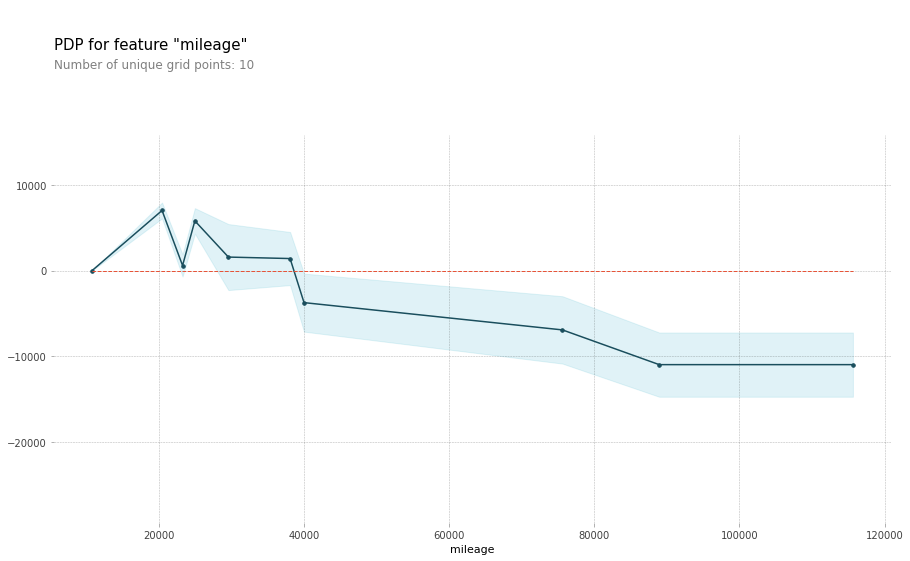

In [25]:
pdp_plot(isolated, feature_name=feature)

### Partial Dependence Plots with 2 features

In [26]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['year', 'mileage']

interaction = pdp_interact(
    model=gb,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

In [27]:
pdp_interact_plot

<function pdpbox.pdp.pdp_interact_plot>

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


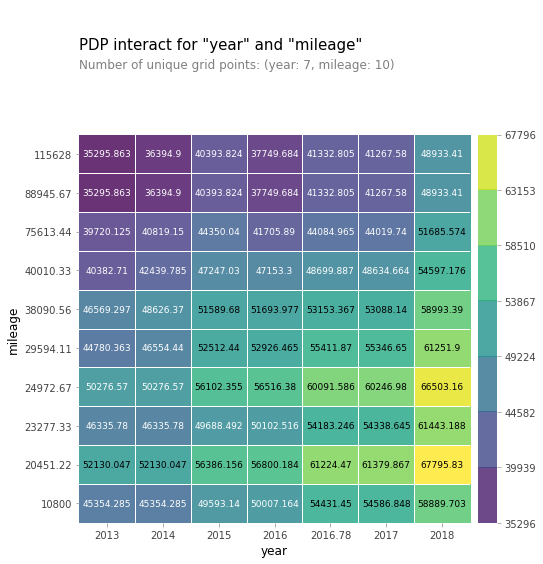

In [28]:
pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

### Make at least 1 Shapley force plot to explain an individual prediction.

In [ ]:
### Let’s do something similar, but with a tuned Random Forest and Shapley Values.

In [51]:
# Assign to X, y
features = ['year', 'battery', 'ludacris_mode', 'all_wheel_drive', 'mileage']
target = ['price']

X_train = train[feature]
y_train = train[target]
X_val = val[feature]
y_val = val[target]
X_test = test[feature]
y_test = test[target]

In [52]:
import category_encoders as ce

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_val = encoder.transform(X_val)
X_test = encoder.transform(X_test)

In [29]:
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_distributions = { 
    'n_estimators': randint(50, 500), 
    'max_depth': [5, 10, 15, 20, None], 
    'max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42), 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=2, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=6, 
    random_state=42
)

search.fit(X_train, y_train);

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of  10 | elapsed:    4.4s remaining:   10.4s
[Parallel(n_jobs=6)]: Done   5 out of  10 | elapsed:    4.6s remaining:    4.6s
[Parallel(n_jobs=6)]: Done   7 out of  10 | elapsed:    5.7s remaining:    2.5s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    6.3s finished


In [30]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)
model = search.best_estimator_

Best hyperparameters {'max_depth': None, 'max_features': 0.6011150117432088, 'n_estimators': 201}
Cross-validation MAE 4925.825


In [31]:
# Get an individual observation to explain.
# For example, the 5th row from the test set.
row = X_train.iloc[[5]]
row

,year,battery,ludacris_mode_No,ludacris_mode_Yes,all_wheel_drive_Yes,all_wheel_drive_No,mileage
96,2018,75,1,0,1,0,22172


In [32]:
# What was the actual price for this Model S?
y_test.iloc[[5]]

5    55995
Name: price, dtype: int64

In [33]:
# What does the model predict for this Model S?
model.predict(row)

array([56024.09452736])

In [34]:
# Why did the model predict this?
# Look at a Shapley Values Force Plot
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)